# <font color=blue>Final Report</font>
## Quantitative Portfolio Management with **GEC Academy**
***
<font size='5'>Session Outline</font>
* Data Mining
* Strategy Construction 
* Backtesting of Performance
* Measuring Risk and Size Position
* Assessing Impact of Transaction Cost 

0. Importing Package

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
import pandas_datareader.data as web
import matplotlib.ticker as mtick
from pandas_datareader.famafrench import get_available_datasets
import getFamaFrenchFactors as gff
import os 
import time

1. Data Mining

In [2]:
stock_price = pd.read_csv('daily.csv', index_col=0)
stock_price.index = pd.to_datetime(stock_price.index)
stock_return = stock_price.pct_change()
print(stock_return.shape)
stock_return.round(4)

(1890, 30)


,AAPL,MSFT,AMZN,GOOGL,META,TSLA,NVDA,BABA,TCEHY,INTC,...,TWTR,TEAM,SHOP,NOW,WDAY,SPLK,MU,NTES,VEEV,ADSK
2016-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-05,-0.0251,0.0046,-0.0050,0.0028,0.0050,0.0001,0.0161,0.0253,-0.0029,-0.0047,...,-0.0284,-0.0233,-0.0159,-0.0008,-0.0067,-0.0078,0.0342,0.0101,0.0105,0.0013
2016-01-06,-0.0196,-0.0182,-0.0018,-0.0029,0.0023,-0.0196,-0.0413,-0.0165,-0.0220,-0.0222,...,-0.0242,0.0105,-0.0004,-0.0307,-0.0368,-0.0351,-0.0405,-0.0011,-0.0307,-0.0141
2016-01-07,-0.0422,-0.0348,-0.0391,-0.0241,-0.0490,-0.0155,-0.0396,-0.0596,-0.0399,-0.0375,...,-0.0528,-0.0030,-0.0249,-0.0219,-0.0356,-0.0400,-0.0394,-0.0478,-0.0644,-0.0598
2016-01-08,0.0053,0.0031,-0.0015,-0.0136,-0.0060,-0.0216,-0.0215,-0.0264,0.0034,-0.0104,...,-0.0138,0.0074,0.0105,-0.0191,-0.0095,-0.0183,-0.0242,-0.0115,-0.0251,-0.0164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-30,0.0231,0.0164,0.0192,0.0050,0.0194,0.0166,0.0363,-0.0024,0.0069,0.0161,...,0.0000,0.0382,0.0132,0.0253,-0.0054,0.0080,-0.0190,-0.0133,0.0133,-0.0076
2023-07-03,-0.0078,-0.0075,-0.0011,0.0017,-0.0033,0.0690,0.0026,0.0086,0.0127,0.0054,...,0.0000,-0.0013,0.0039,0.0016,-0.0058,-0.0052,0.0125,0.0271,-0.0065,-0.0044
2023-07-05,-0.0059,0.0005,0.0012,0.0154,0.0292,0.0095,-0.0023,0.0027,-0.0130,-0.0330,...,0.0000,0.0308,-0.0063,0.0051,-0.0089,0.0069,-0.0288,-0.0119,0.0119,0.0007
2023-07-06,0.0025,0.0092,-0.0155,-0.0135,-0.0081,-0.0210,-0.0051,-0.0055,-0.0301,-0.0166,...,0.0000,-0.0401,-0.0405,-0.0176,-0.0148,-0.0177,-0.0134,-0.0239,-0.0172,-0.0137


2. Strategy Construction 

In [3]:
def performance_evaluation(returns):
    mean = returns.mean() 
    std = returns.std() 
    sharpe_ratio = mean / std
    skewness = returns.skew() 
    kurtosis = returns.kurtosis() + 3 

    cumulative_returns = (1 + returns).cumprod() - 1
    high_water_mark = cumulative_returns.cummax()
    drawdown = 1 - (cumulative_returns+1) / (high_water_mark+1)
    max_drawdown = drawdown.max()

    return sharpe_ratio, max_drawdown, skewness, kurtosis, cumulative_returns

In [4]:
N = 30
test_date = '20190101'
training_set = stock_return.loc[stock_return.index < test_date].iloc[N+1:].copy()
test_set = stock_return.loc[stock_return.index >= test_date].copy()

MA = stock_return.rolling(N).mean().shift(1)
training_MA = MA.loc[MA.index < test_date].iloc[N+1:].copy()
test_MA = MA.loc[MA.index >= test_date].copy()

tickers = stock_return.columns.to_list()
momentum_index = pd.DataFrame(index=tickers, columns=["alpha", "beta", "train_rmse", "sigma", "rsquared"], dtype=float)

error = pd.DataFrame()

for i in tickers:
    x = sm.add_constant(training_MA[i])
    y = training_set[i]
    result = sm.OLS(y, x).fit()
    predict_y = result.predict(x)
    train_rmse = np.sqrt(((y - predict_y) ** 2).mean())
    sigma = (y - predict_y).std()
    alpha, beta = result.params
    momentum_index.loc[i, ["alpha", "beta", "train_rmse", "sigma", "rsquared"]] = alpha, beta, train_rmse, sigma, result.rsquared
    error = pd.concat([error, y - predict_y], axis=1)

momentum_index


,alpha,beta,train_rmse,sigma,rsquared
AAPL,0.000715,0.117764,0.014421,0.014431,0.000553
MSFT,0.002360,-1.090426,0.013712,0.013722,0.013736
AMZN,0.002024,-0.282208,0.017534,0.017547,0.001923
GOOGL,0.000796,-0.359420,0.013398,0.013407,0.002760
META,0.000537,-0.144739,0.017071,0.017083,0.000464
TSLA,0.001882,-0.447947,0.027948,0.027967,0.004992
NVDA,0.001927,0.249905,0.028836,0.028856,0.002184
BABA,0.001208,-0.015447,0.019273,0.019286,0.000007
TCEHY,0.001451,-0.129198,0.019628,0.019641,0.000422
INTC,0.001113,-0.286440,0.015611,0.015622,0.001696


In [5]:
test_portfolio_weights = np.matmul(test_MA.multiply(momentum_index["beta"]) + momentum_index["alpha"], np.linalg.inv(error.cov()))
test_portfolio_weights.columns = tickers
test_portfolio_weights = test_portfolio_weights.div(test_portfolio_weights.abs().sum(axis="columns"), axis="rows")
test_portfolio_returns = (test_portfolio_weights * test_set).sum(axis="columns")
test_sharpe_ratio, test_max_drawdown, test_skewness, test_kurtosis, test_cumulative_returns = performance_evaluation(test_portfolio_returns)

In [6]:
performance_evaluation(test_portfolio_returns)

(0.060928612170654636,
 0.059074945703996184,
 0.08694050653352614,
 9.048693840881096,
 2019-01-02   -0.002637
 2019-01-03   -0.001248
 2019-01-04    0.001007
 2019-01-07    0.003251
 2019-01-08    0.000248
                 ...   
 2023-06-30    0.368882
 2023-07-03    0.368899
 2023-07-05    0.370111
 2023-07-06    0.371572
 2023-07-07    0.368662
 Length: 1136, dtype: float64)

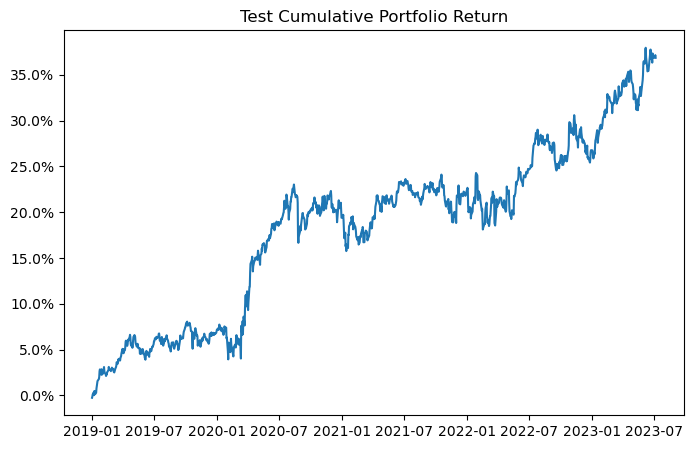

In [7]:
plt.figure(figsize=(8, 5))
plt.plot(test_cumulative_returns)
plt.title("Test Cumulative Portfolio Return", fontsize=12)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

3. Backtesting of Performance

In [8]:
training_portfolio_weights = np.matmul(training_MA.multiply(momentum_index["beta"]) + momentum_index["alpha"], np.linalg.inv(error.cov()))
training_portfolio_weights.columns = tickers
training_portfolio_weights = training_portfolio_weights.div(training_portfolio_weights.abs().sum(axis="columns"), axis="rows")
training_portfolio_returns = (training_portfolio_weights * training_set).sum(axis="columns")
training_sharpe_ratio, training_max_drawdown, training_skewness, training_kurtosis, training_cumulative_returns = performance_evaluation(training_portfolio_returns)

Text(0.5, 0, '')

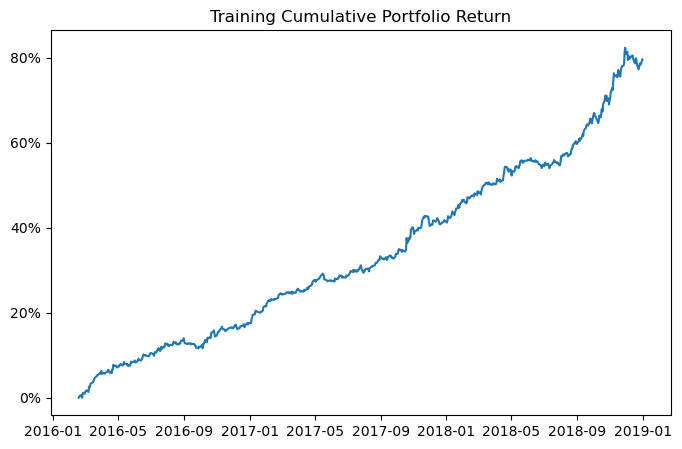

In [9]:
plt.figure(figsize=(8, 5))
plt.plot(training_cumulative_returns)
plt.title("Training Cumulative Portfolio Return", fontsize=12)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.xlabel("")

4. Measuring Risk and Size Position

In [19]:
training_sharpe_ratio, training_max_drawdown, training_skewness, training_kurtosis

(0.29480262165430215,
 0.014449149736750933,
 0.5399100725486418,
 4.6484260382404745)

In [20]:
test_sharpe_ratio, test_max_drawdown, test_skewness, test_kurtosis

(0.040145179496454395,
 0.0766740125623343,
 0.060412501781294196,
 6.699012378488705)

5. Assessing Impact of Transaction Cost 

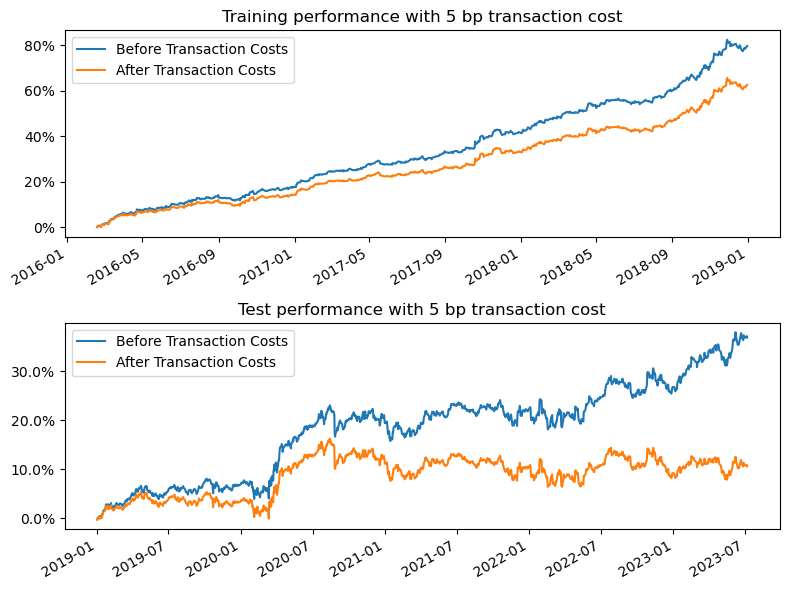

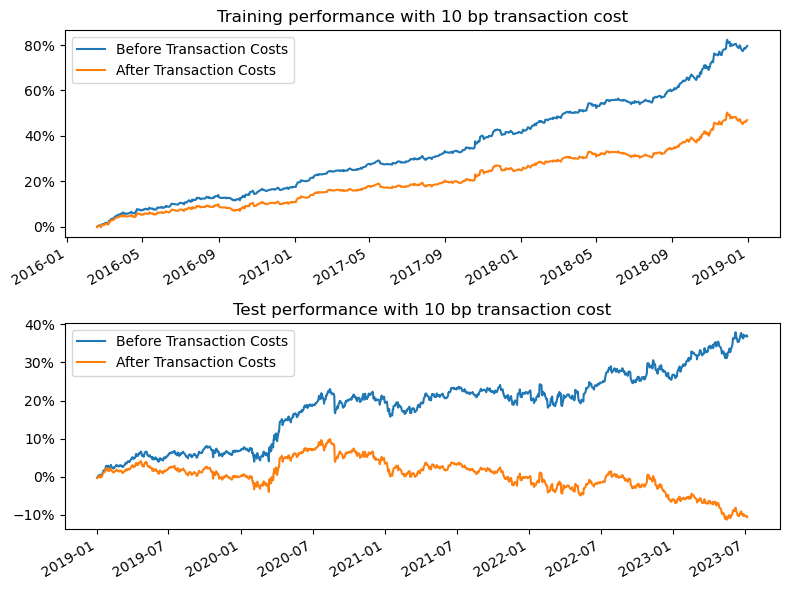

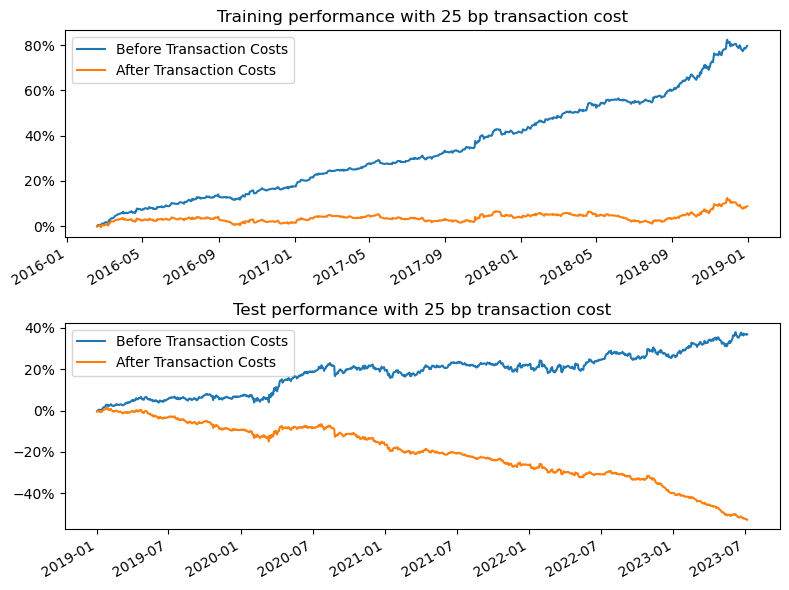

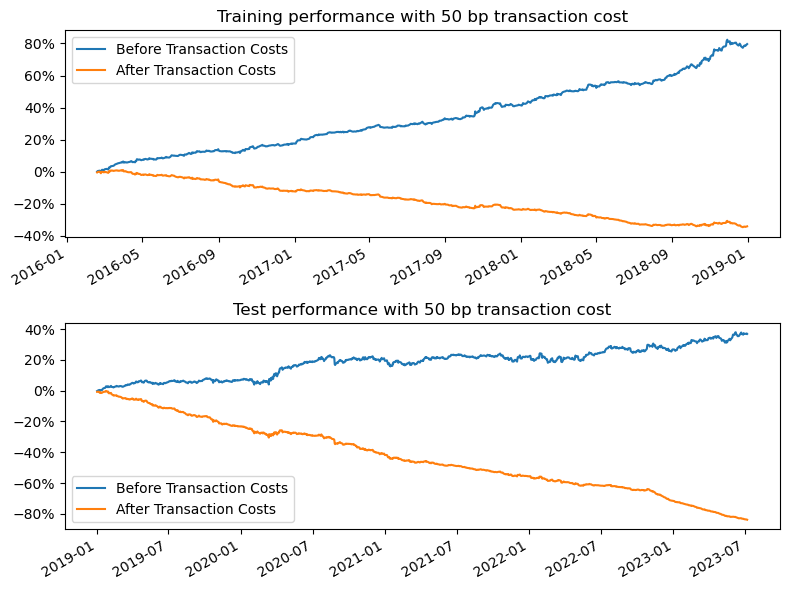

In [12]:
def transaction_amount(weights, prices_shift1):
    return ((weights / prices_shift1).diff(1).abs() * prices_shift1).sum(axis="columns", skipna=False).fillna(1)

training_px_df = stock_price.shift(1).loc[training_portfolio_weights.index]
test_px_df = stock_price.shift(1).loc[test_portfolio_weights.index]

cost_coefficients = np.array([5, 10, 25, 50])/10000
performance_df = pd.DataFrame(index=cost_coefficients, dtype=float,
                              columns=["train_sharpe_ratio", "train_max_drawdown", "train_skewness", "train_kurtosis", 
                                       "test_sharpe_ratio", "test_max_drawdown", "test_skewness", "test_kurtosis"])
for cost_coefficient in cost_coefficients:

    training_return_with_transaction_cost = training_portfolio_returns - cost_coefficient * transaction_amount(training_portfolio_weights, training_px_df)
    training_sharpe_ratio, training_max_drawdown, training_skewness, training_kurtosis, training_cumulative_performance = performance_evaluation(training_return_with_transaction_cost)
    training_sharpe_ratio *= np.sqrt(252)

    test_return_with_transaction_cost = test_portfolio_returns - cost_coefficient * transaction_amount(test_portfolio_weights, test_px_df)
    test_sharpe_ratio, test_max_drawdown, test_skewness, test_kurtosis, test_cumulative_performance = performance_evaluation(test_return_with_transaction_cost)
    test_sharpe_ratio *= np.sqrt(252)
    
    performance_df.loc[cost_coefficient, :] = training_sharpe_ratio, training_max_drawdown, training_skewness, training_kurtosis, test_sharpe_ratio, test_max_drawdown, test_skewness, test_kurtosis
    

    fig, axes = plt.subplots(2, 1, figsize=(8, 6))

    ax = axes[0]
    training_cumulative_returns.plot(ax=ax, label="Before Transaction Costs")
    training_cumulative_performance.plot(ax=ax, label="After Transaction Costs")
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
    ax.legend()
    ax.set_title(f"Training performance with {int(cost_coefficient*10000)} bp transaction cost", fontsize=12)
    ax.set_xlabel("")
    

    ax = axes[1]
    test_cumulative_returns.plot(ax=ax, label="Before Transaction Costs")
    test_cumulative_performance.plot(ax=ax, label="After Transaction Costs")
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
    ax.legend()
    ax.set_title(f"Test performance with {int(cost_coefficient*10000)} bp transaction cost", fontsize=12)
    ax.set_xlabel("")
    fig.tight_layout()
    plt.show()

In [13]:
weights = []

for N in range(1, 100):
    test_date = '20190101'
    training_set = stock_return.loc[stock_return.index < test_date].iloc[N+1:].copy()
    test_set = stock_return.loc[stock_return.index >= test_date].copy()

    MA = stock_return.rolling(N).mean().shift(1)
    training_MA = MA.loc[MA.index < test_date].iloc[N+1:].copy()
    test_MA = MA.loc[MA.index >= test_date].copy()

    tickers = stock_return.columns.to_list()
    momentum_index = pd.DataFrame(index=tickers, columns=["alpha", "beta", "train_rmse", "sigma", "rsquared"], dtype=float)

    error = pd.DataFrame()

    for i in tickers:
        x = sm.add_constant(training_MA[i])
        y = training_set[i]
        result = sm.OLS(y, x).fit()
        predict_y = result.predict(x)
        train_rmse = np.sqrt(((y - predict_y) ** 2).mean())
        sigma = (y - predict_y).std()
        alpha, beta = result.params
        momentum_index.loc[i, ["alpha", "beta", "train_rmse", "sigma", "rsquared"]] = alpha, beta, train_rmse, sigma, result.rsquared
        error = pd.concat([error, y - predict_y], axis=1)

    test_portfolio_weights = np.matmul(test_MA.multiply(momentum_index["beta"]) + momentum_index["alpha"], np.linalg.inv(error.cov()))
    test_portfolio_weights.columns = tickers
    test_portfolio_weights = test_portfolio_weights.div(test_portfolio_weights.abs().sum(axis="columns"), axis="rows")
    test_portfolio_returns = (test_portfolio_weights * test_set).sum(axis="columns")
    test_sharpe_ratio, test_max_drawdown, test_skewness, test_kurtosis, test_cumulative_returns = performance_evaluation(test_portfolio_returns)

    training_portfolio_weights = np.matmul(training_MA.multiply(momentum_index["beta"]) + momentum_index["alpha"], np.linalg.inv(error.cov()))
    training_portfolio_weights.columns = tickers
    training_portfolio_weights = training_portfolio_weights.div(training_portfolio_weights.abs().sum(axis="columns"), axis="rows")
    training_portfolio_returns = (training_portfolio_weights * training_set).sum(axis="columns")
    training_sharpe_ratio, training_max_drawdown, training_skewness, training_kurtosis, training_cumulative_returns = performance_evaluation(training_portfolio_returns)
    
    weights.append([training_sharpe_ratio, test_sharpe_ratio])

In [14]:
a = pd.DataFrame(weights, index=range(1, 100))
a.columns = ['training_sharpe_ratio', 'test_sharpe_ratio']
a.tail(50)

,training_sharpe_ratio,test_sharpe_ratio
50,0.255432,0.045509
51,0.263059,0.038282
52,0.265966,0.035077
53,0.275003,0.033743
54,0.268954,0.030598
55,0.275590,0.032494
56,0.284329,0.038163
57,0.291509,0.032786
58,0.274817,0.018186
59,0.265027,0.021894


In [15]:
x1 = sm.add_constant(a.index)
y1 = a[['training_sharpe_ratio']]
result1 = sm.OLS(y1, x1).fit()
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     training_sharpe_ratio   R-squared:                       0.425
Model:                               OLS   Adj. R-squared:                  0.419
Method:                    Least Squares   F-statistic:                     71.78
Date:                   Wed, 12 Jul 2023   Prob (F-statistic):           2.63e-13
Time:                           13:17:47   Log-Likelihood:                 267.73
No. Observations:                     99   AIC:                            -531.5
Df Residuals:                         97   BIC:                            -526.3
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2459      0.003     74.223      0.000       0.239       0.252
x1             0.0005   5.75e-05      8.472      0.000       0.000       0.001
==============================================================================
Omnibus:                        4.061   Durbin-Watson:                   0.368
Prob(Omnibus):                  0.131   Jarque-Bera (JB):                3.707
Skew:                           0.289   Prob(JB):                        0.157
Kurtosis:                       3.751   Cond. No.                         116.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'training_sharpe_ratio')

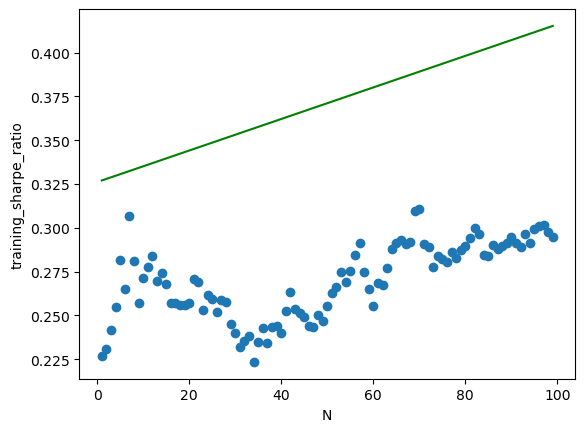

In [ ]:
x = a.index
plt.scatter(x, y1)
plt.plot(x, 0.0009*x+0.3261, color='green')
plt.xlabel('N')
plt.ylabel('training_sharpe_ratio')